In [109]:
#Imports

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [113]:
#paths

In [115]:
data_train_path = 'data/train'
data_val_path = 'data/validation'
data_test_path = 'data/test'
model_save_path = 'models/image_classify.keras'

In [117]:
img_width, img_height = 224, 224
batch_size = 32

In [119]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 3115 files belonging to 36 classes.


In [121]:
data_cat = data_train.class_names
print(f"Classes found ({len(data_cat)}): {data_cat}")

Classes found (36): ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [123]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 351 files belonging to 36 classes.


In [125]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 359 files belonging to 36 classes.


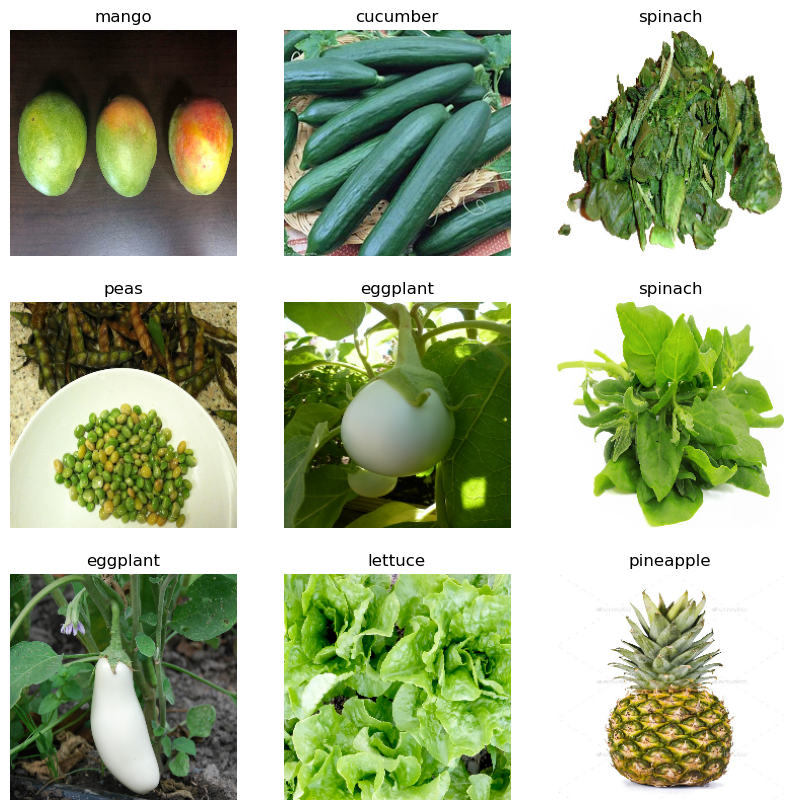

In [127]:
plt.figure(figsize=(10,10))
for images, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [129]:
# Prefetch for performance optimization

In [131]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = data_train.prefetch(buffer_size=AUTOTUNE)
val_ds = data_val.prefetch(buffer_size=AUTOTUNE)
test_ds = data_test.prefetch(buffer_size=AUTOTUNE)

In [133]:
num_classes = len(data_cat)

In [135]:
print(f"Number of classes: {num_classes}")

Number of classes: 36


In [137]:
#Data Augmentation

In [139]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [141]:
#Model: Transfer Learning with MobileNetV2 

In [143]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [145]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [147]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [149]:
#Callbacks

In [151]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

In [153]:
#Train the Model

In [155]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.3094 - loss: 2.7197 - val_accuracy: 0.8291 - val_loss: 0.6040
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 97s 979ms/step - accuracy: 0.7390 - loss: 0.9091 - val_accuracy: 0.8575 - val_loss: 0.4229
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 975ms/step - accuracy: 0.8002 - loss: 0.6545 - val_accuracy: 0.8803 - val_loss: 0.3790
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8056 - loss: 0.6179 - val_accuracy: 0.9145 - val_loss: 0.2976
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8393 - loss: 0.4825 - val_accuracy: 0.9117 - val_loss: 0.2961
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 976ms/step - accuracy: 0.8615 - loss: 0.4563 - val_accuracy: 0.9316 - val_loss: 0.2523
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 97s 982ms/step - accuracy: 0.8573 - loss: 0.3983 - val_accuracy: 0.9060 - val_loss: 0.2704
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8870 - loss: 0.3411 - val_accuracy: 0.9

In [ ]:
#Plot Accuracy and Loss

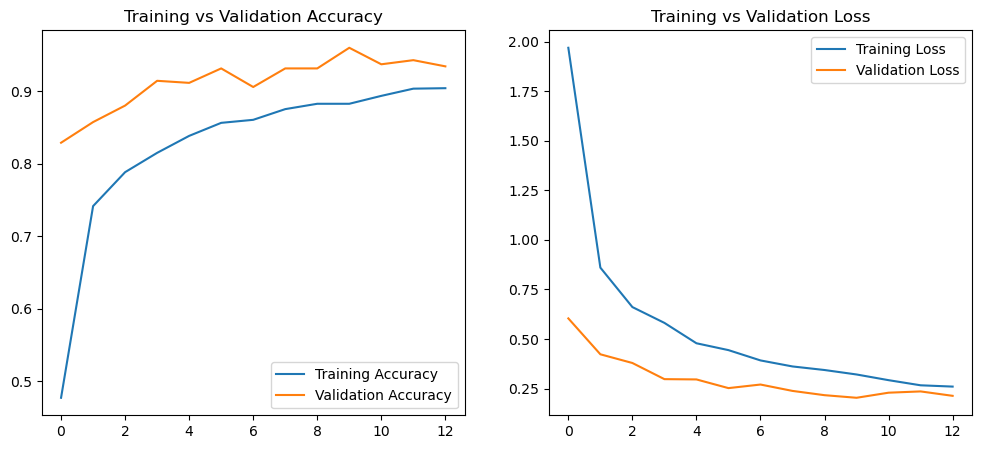

In [157]:
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [159]:
#Evaluate on Test Set

In [161]:
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

x_test = tf.concat(test_images, axis=0)
y_test = tf.concat(test_labels, axis=0)

pred_logits = model.predict(x_test)
y_pred = np.argmax(pred_logits, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 753ms/step


In [162]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=data_cat))

Classification Report:
               precision    recall  f1-score   support

        apple       0.75      0.90      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.80      0.89        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.77      1.00      0.87        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.91      1.00      0.95        10
         corn       0.75      0.90      0.82        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       0.90      0.90      0.90        10
         kiwi       1.00      1.00      1

In [164]:
#Confusion Matrix Plot

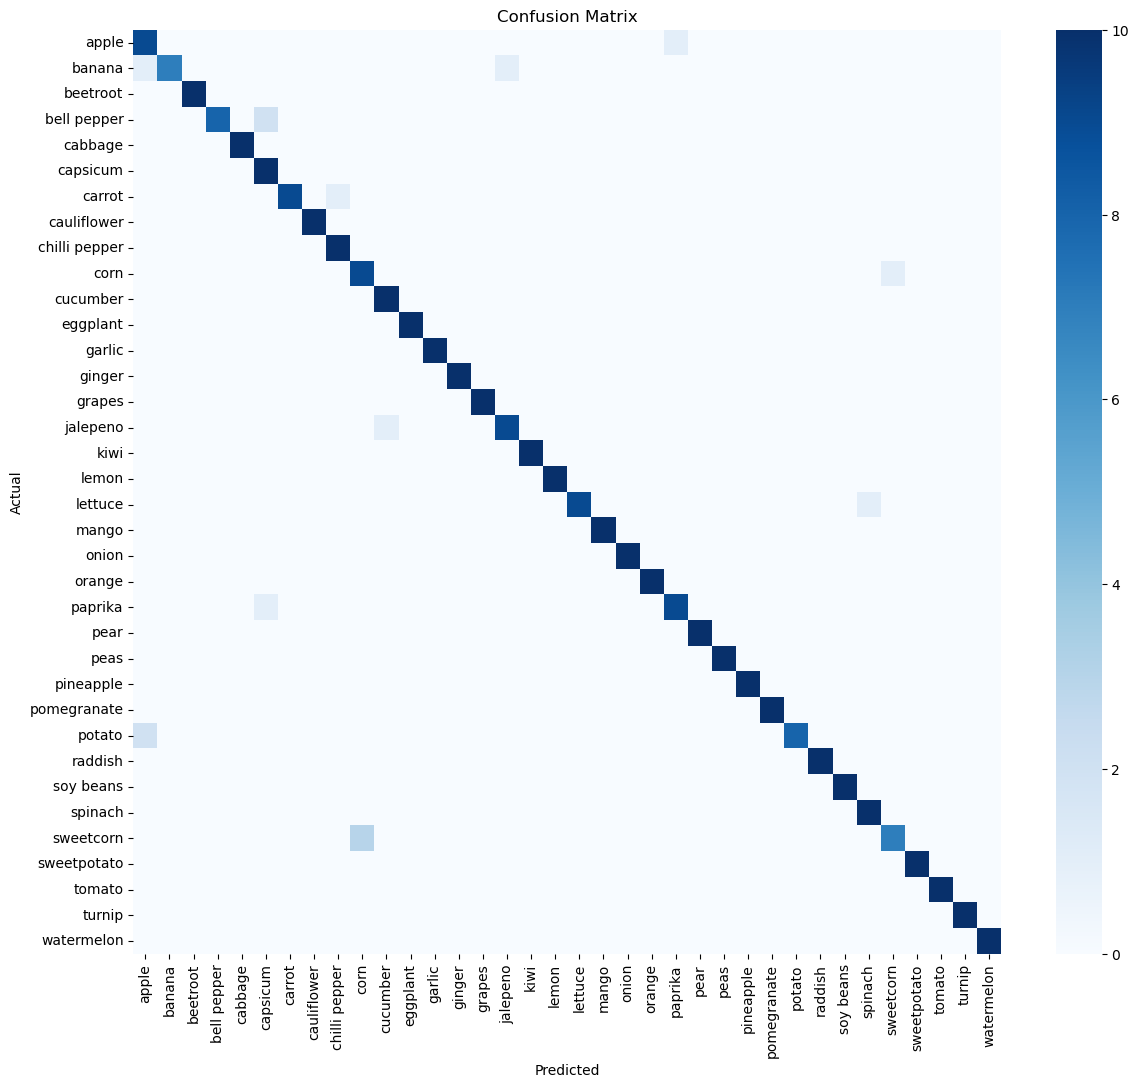

In [167]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=data_cat, yticklabels=data_cat)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [169]:
#Save the Model

In [171]:
model.save(model_save_path)

In [173]:
#Example Inference on a Single Image

In [175]:
def predict_single_image(image_path, model, class_names):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = np.max(score) * 100
    print(f"Prediction: {predicted_class} ({confidence:.2f}%)")

sample_image_path = 'Sample/Apple.jpg'
predict_single_image(sample_image_path, model, data_cat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Prediction: apple (98.44%)
